# Prueba de biblioteca Lifetimes

Instalando dependencias:

In [49]:
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install lifetimes
!{sys.executable} -m pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Importando dependencias:

In [50]:
import pandas as pd
from lifetimes.datasets import load_cdnow_summary
from lifetimes.datasets import load_transaction_data
from lifetimes import ParetoNBDFitter
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes.plotting import plot_history_alive
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.utils import calibration_and_holdout_data

## Cargando el dataset de prueba de la biblioteca Lifetimes

Este dataset está basado en información de la empresa CDNow. Inicialmente ya se realizó el análisis RFM y la data contiene los siguientes atributos:

- **Recency**: ¿Hace cuánto tiempo compró un cliente? o ¿Cuánto tiempo pasó para que el cliente realizara su última compra?
- **Frecuency**: ¿Con qué frecuencia/consistencia compra un cliente?
- **T**: Unidad de tiempo, en este caso representa una semana.

In [51]:
data = load_cdnow_summary(index_col=[0])
print(data)

      frequency  recency      T
ID                             
1             2    30.43  38.86
2             1     1.71  38.86
3             0     0.00  38.86
4             0     0.00  38.86
5             0     0.00  38.86
...         ...      ...    ...
2353          0     0.00  27.00
2354          5    24.29  27.00
2355          0     0.00  27.00
2356          4    26.57  27.00
2357          0     0.00  27.00

[2357 rows x 3 columns]


Creando y ajustando el modelo de Pareto / NBD con el dataset:

In [52]:
model = BetaGeoFitter(penalizer_coef=0.0)
model.fit(data['frequency'], data['recency'], data['T'])
print(model)


<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.79, alpha: 4.41, b: 2.43, r: 0.24>


## Matriz de Frecuencia/Recencia

Si un cliente ha comprado todos los días durante tres semanas seguidas, y no ha vuelto a comprar en meses. ¿Cuáles son las posibilidades de que este cliente todavía esté "vivo"? Muy pequeña. 

Por otro lado, un cliente que históricamente compra una vez al trimestre y compró el último trimestre, probablemente aún esté vivo. 

Podemos visualizar esta relación utilizando la matriz Frecuencia/Recency, que calcula el número esperado de transacciones que un cliente artificial realizará en el próximo período de tiempo, dada su Recency (edad en la última compra) y Frecuency (el número de transacciones repetidas).

<AxesSubplot: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

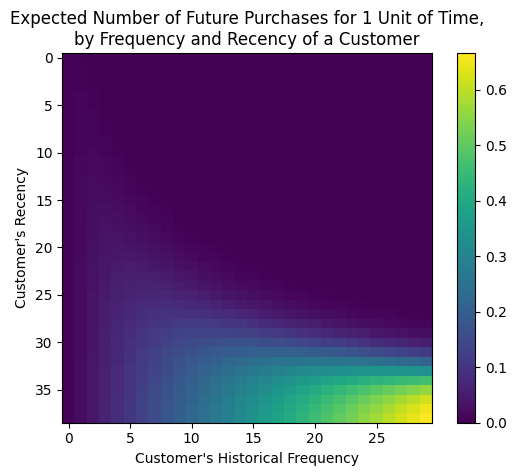

In [53]:
plot_frequency_recency_matrix(model)

Podemos ver que si un cliente ha comprado en 25 periodos, y su última compra la realizó luego de 35 semanas, entonces podemos considerarlo como uno de los mejores clientes (abajo a la derecha). Los clientes más fríos son los que están en la esquina superior derecha: compraron mucho rápido y no los hemos visto en semanas.

También está la “cola” alrededor (5,25). Eso representa al cliente que compra con poca frecuencia, pero lo hemos visto recientemente, por lo que podría volver a comprar; no estamos seguros de si está muerto o solo entre compras.

Otra matriz interesante para observar es la probabilidad de seguir vivo:

<AxesSubplot: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

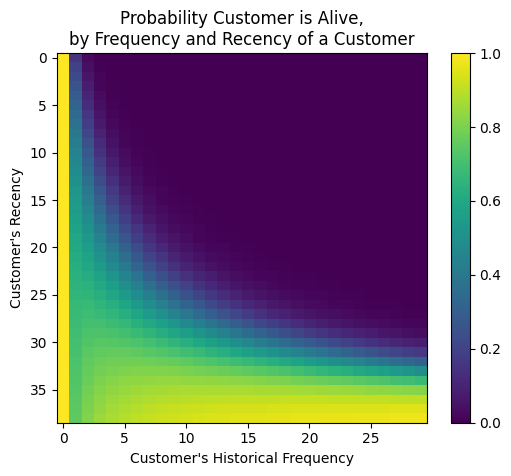

In [54]:
plot_probability_alive_matrix(model)


## Ordenando a los clientes de mejor a peor

Ahora vamos a clasificar a los clientes desde "las compras esperadas más altas en el próximo período" hasta las más bajas. El modelo permite predecir las compras esperadas de un cliente en el próximo período utilizando su historial.

In [55]:
t = 1
data['predicted_purchases'] = model.conditional_expected_number_of_purchases_up_to_time(
    t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)


,frequency,recency,T,predicted_purchases
ID,,,,
509,18,35.14,35.86,0.424877
841,19,34.00,34.14,0.474738
1981,17,28.43,28.86,0.486526
157,29,37.71,38.00,0.662396
1516,26,30.86,31.00,0.710623


Podemos ver que el cliente que ha realizado 26 compras, y nos compró muy recientemente, probablemente volverá a comprar en el próximo período.

## Evaluación del ajuste del modelo

Podemos predecir y podemos visualizar el comportamiento de nuestros clientes, pero el modelo es correcto? En el siguiente gráfico se comparan sus datos con datos artificiales simulados con los parámetros del modelo ajustado.

<AxesSubplot: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

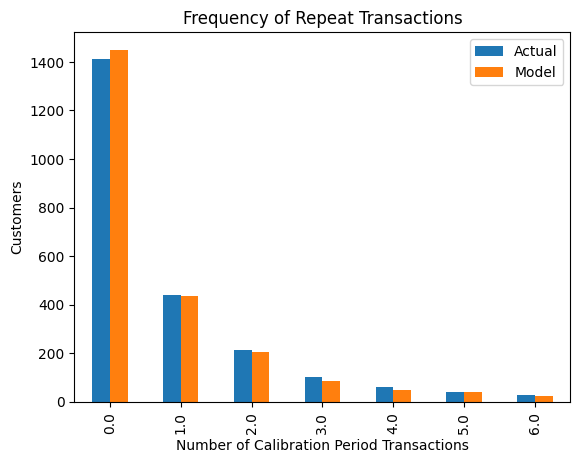

In [56]:
plot_period_transactions(model)



Podemos ver que nuestros datos reales y nuestros datos simulados se alinean bien. Esto prueba que nuestro modelo no es malo.

# Trabajando con tabla de pedidos

La mayoría de las veces, el conjunto de datos que se tiene estará en el nivel de transacción. Lifetimes tiene algunas funciones de utilidad para transformar esos datos transaccionales (una fila por compra) en datos de resumen FRM.

In [57]:
transaction_data = load_transaction_data()
transaction_data['date'] = pd.to_datetime(
    transaction_data['date'], format='%Y-%m-%d %H:%M')

print(transaction_data.head())


        date  id
0 2014-03-08   0
1 2014-05-21   1
2 2014-03-14   2
3 2014-04-09   2
4 2014-05-21   2


In [58]:
summary = summary_data_from_transaction_data(
    transaction_data, 'id', 'date', observation_period_end='2014-12-31')

print(summary.head())


    frequency  recency      T
id                           
0         0.0      0.0  298.0
1         0.0      0.0  224.0
2         6.0    142.0  292.0
3         0.0      0.0  147.0
4         2.0      9.0  183.0


In [59]:
model.fit(summary['frequency'], summary['recency'], summary['T'])
print(model)

<lifetimes.BetaGeoFitter: fitted with 5000 subjects, a: 1.85, alpha: 1.86, b: 3.18, r: 0.16>


## Más ajuste del modelo

Con los datos transaccionales, podemos dividir el conjunto de datos en un conjunto de datos de período de calibración y un conjunto de datos de reserva. Esto es importante ya que queremos probar cómo funciona nuestro modelo en datos que aún no se han visto (piense en la validación cruzada en la literatura estándar de aprendizaje automático). Lifetimes tiene una función para particionar nuestro conjunto de datos de esta manera:

In [60]:
summary_cal_holdout = calibration_and_holdout_data(transaction_data, 'id', 'date',
                                                   calibration_period_end='2014-09-01',
                                                   observation_period_end='2014-12-31')
print(summary_cal_holdout.head())


    frequency_cal  recency_cal  T_cal  frequency_holdout  duration_holdout
id                                                                        
0             0.0          0.0  177.0                0.0             121.0
1             0.0          0.0  103.0                0.0             121.0
2             6.0        142.0  171.0                0.0             121.0
3             0.0          0.0   26.0                0.0             121.0
4             2.0          9.0   62.0                0.0             121.0


Con este conjunto de datos, podemos realizar ajustes en las columnas `_cal` y probar en las columnas `_holdout`:

<AxesSubplot: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

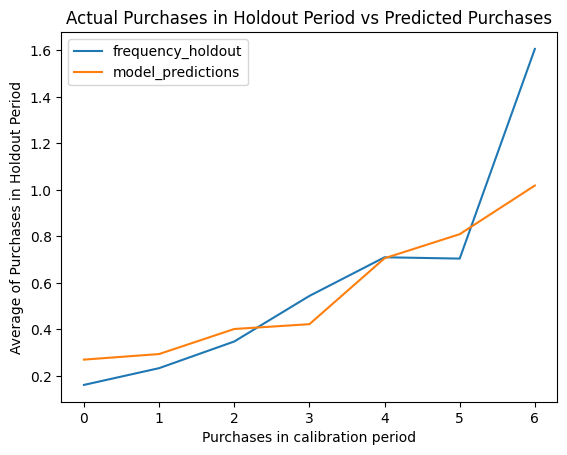

In [61]:
model.fit(summary_cal_holdout['frequency_cal'],
        summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(model, summary_cal_holdout)


## Predicciones de clientes
Con base en el historial del cliente, podemos predecir cómo serán las compras futuras de un individuo:

In [64]:
t = 10  # predecir compras en 10 periodos

individual = summary.iloc[20]

print(individual)
model.predict(t, individual['frequency'],
              individual['recency'], individual['T'])


frequency      2.0
recency       96.0
T            159.0
Name: 20, dtype: float64


0.05765116591827104

## Historiales de probabilidad de clientes
Dado el historial de transacciones de un cliente, podemos calcular su probabilidad histórica de estar vivo, de acuerdo con nuestro modelo entrenado. Por ejemplo:

<AxesSubplot: title={'center': 'History of P_alive'}, ylabel='P_alive'>

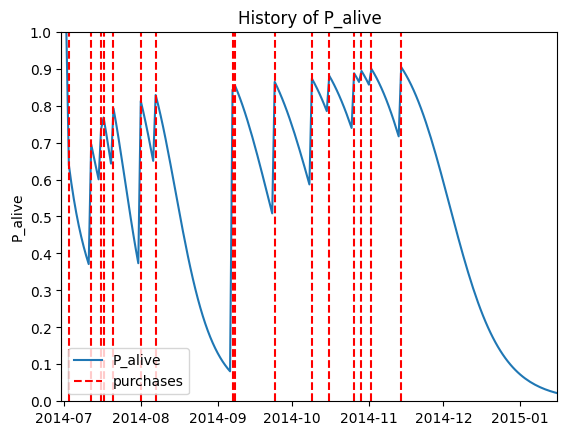

In [63]:
id = 35
days_since_birth = 200
sp_trans = transaction_data.loc[transaction_data['id'] == id]
plot_history_alive(model, days_since_birth, sp_trans, 'date')
